In [198]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd

import copulagp.marginal as mg
from copulagp import bvcopula
import torch
from scipy import interpolate

LENGTH = 200 #cm long VR corridor

def cond_interp(cond_u,u,rate,pos,bins=100,av=6):  
    '''
    Interpolates the inverse CCDF
    cond_u: conditioned variable from [0,1]
    u: a variable prior to conditioning [0,1]
    rate: a firing rate that corresponds to u
    pos: conditioning variable
    bins: number of bins
    av: number of neighbouring bins that are included
        in ccdf estimation (rule of thumb:
        make higher untill fix messages disappear)
    '''
    cond_y = np.empty_like(cond_u)
    for i in range(bins):
        mask_av = (pos>=(i-av)/bins) & (pos<=(i+av+1)/bins)
        mask = (pos>=i/bins) & (pos<=(i+1)/bins)
        if cond_u[mask].min()<u[mask_av].min():
            print('Fixing min')
            cond_u[mask & (cond_u<u[mask_av].min())] = u[mask_av].min()
        if cond_u[mask].max()>u[mask_av].max():
            print('Fixing max')
            cond_u[mask & (cond_u>u[mask_av].max())] = u[mask_av].max()
        interp = interpolate.interp1d(u[mask_av],rate[mask_av],
                                    kind='slinear')
        cond_y[mask] = interp(cond_u[mask])
        if np.any(cond_y==np.inf):
            print(cond_u[cond_y==np.inf],pos[cond_y==np.inf],u[mask].min(),rate[mask].min(),u[mask].max(),rate[mask].max())
    cond_y[rate<0.01] = rate[rate<0.01] # remove transformed jitter
    assert np.all(cond_y==cond_y)
    assert np.all(cond_y!=np.inf), cond_u[cond_y==np.inf]
    return cond_y

In [199]:
# session = 'M7_D21_2020-11-26_16-09-48'
session = 'M3_D18_2020-11-21_14-29-49'
data = pd.read_pickle(f'{session}_u.pkl')
data.iloc[2]

session_id                               M3_D18_2020-11-21_14-29-49
cluster_id                                                       12
spikes_per50ms    [[0.17351680745402503, 0.2128912512133495, 0.2...
u_vel_t0          [0.06973600729436508, 0.0691285010862015, 0.07...
u_rate_t0         [0.0283606961094209, 0.030153486130715286, 0.0...
u_vel_t1          [0.0035819461196700078, 8.090774314118034e-05,...
u_rate_t1         [0.020286581043474576, 0.022004345574204814, 0...
Name: 10, dtype: object

In [201]:
session_id=22
u_vel_t0=data.iloc[session_id].u_vel_t0
u_rate_t0=data.iloc[session_id].u_rate_t0
u_vel_t1=data.iloc[session_id].u_vel_t1
u_rate_t1=data.iloc[session_id].u_rate_t1
[ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
pos_t0 = ds_pos[trial_type==0]/LENGTH
pos_t1 = ds_pos[trial_type==1]/LENGTH
ds_rate_t0 = ds_rate[trial_type==0]
ds_rate_t1 = ds_rate[trial_type==1]

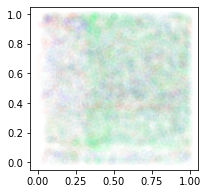

In [202]:
from matplotlib import cm
cmap = cm.rainbow
plt.figure(figsize=(3,3))
plt.scatter(u_vel_t1,u_rate_t1,color=cmap(pos_t1),alpha=0.01)

# Gauss

In [203]:
device='cuda:0'
train_x = torch.tensor(pos_t1).float().to(device=device)
train_y = torch.tensor(np.array([u_rate_t1,u_vel_t1]).T).float().to(device=device)

likelihoods = [bvcopula.GaussianCopula_Likelihood()]
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                     device=device, prior_rbf_length=1.)
print(f"WAIC: {waic}")

CPU times: user 16.1 s, sys: 56.9 ms, total: 16.1 s
Wall time: 16.1 s
WAIC: -0.010099426843225956


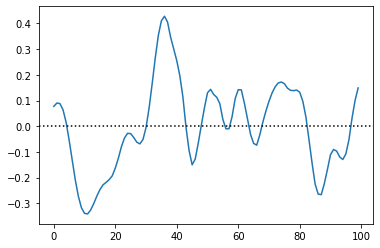

In [204]:
test_x = torch.linspace(0,1,100).float().to(device=device)
theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
plt.plot(theta)
plt.axhline(0,color='k',linestyle=':')

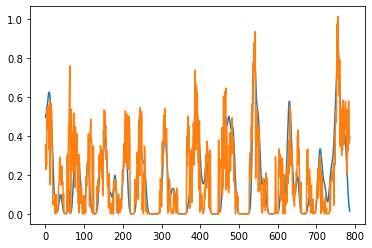

In [205]:
model.gp_model.eval()
# copula = model.marginalize(train_x) # marginalize the GP
with torch.no_grad():
    f = model.gp_model(train_x).mean
copula = model.likelihood.get_copula(f) 
cond_u = copula.ccdf(train_y).cpu().numpy()
cond_y = cond_interp(cond_u,u_rate_t1,ds_rate_t1,pos_t1,bins=10)

plt.plot(ds_rate_t1[10000:11000])
plt.plot(cond_y[10000:11000])
# rate_HPC[::200,5].shape
# cond_u.shape

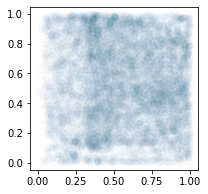

In [206]:
plt.figure(figsize=(3,3))
plt.scatter(u_vel_t1,cond_u,alpha=0.01)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, '')

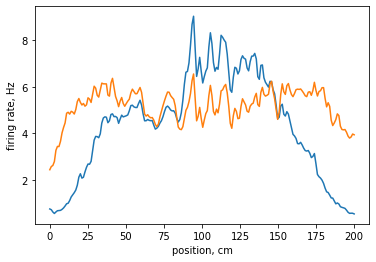

In [207]:
n_bins = 200
m=5
averages = np.empty((2,n_bins))
for i in tqdm(range(n_bins)):
    mask = (pos_t1>=(i-m)/n_bins) & (pos_t1 <=(i+1+m)/n_bins)
    w = np.exp(-(pos_t1[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
    w = w/w.sum()
#     print(w)
    averages[0,i] =  20*(ds_rate_t1[mask] * w).sum()
    averages[1,i] =  20*(cond_y[mask] * w).sum()
plt.plot(np.linspace(0,LENGTH,n_bins),averages.T)
plt.xlabel('position, cm')
plt.ylabel('firing rate, Hz')
plt.title('')

# Many

0it [00:00, ?it/s]

CPU times: user 18.1 s, sys: 196 ms, total: 18.3 s
Wall time: 12.6 s
WAIC: -0.008333446457982063
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 8.3 s, sys: 35.8 ms, total: 8.33 s
Wall time: 8.32 s
WAIC: -0.015299921855330467


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 26.1 s, sys: 197 ms, total: 26.3 s
Wall time: 20.6 s
WAIC: -0.024455301463603973


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 18.8 s, sys: 59.3 ms, total: 18.9 s
Wall time: 18.8 s
WAIC: -0.06379064917564392


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 18.1 s, sys: 177 ms, total: 18.2 s
Wall time: 12.6 s
WAIC: -0.04116295278072357
Fixing min
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 35.5 ms, total: 13.5 s
Wall time: 13.5 s
WAIC: -0.0717582255601883
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 26.3 s, sys: 186 ms, total: 26.5 s
Wall time: 20.8 s
WAIC: -0.021573634818196297


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 8.36 s, sys: 23.7 ms, total: 8.39 s
Wall time: 8.38 s
WAIC: -0.018680915236473083


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 18.1 s, sys: 201 ms, total: 18.3 s
Wall time: 12.7 s
WAIC: -0.022984124720096588


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 43.6 ms, total: 13.4 s
Wall time: 13.4 s
WAIC: -0.03580324351787567
Fixing min
Fixing min
Fixing min


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 18.1 s, sys: 178 ms, total: 18.3 s
Wall time: 12.6 s
WAIC: -0.010537190362811089


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 27.8 ms, total: 13.4 s
Wall time: 13.4 s
WAIC: -0.03516954928636551


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 18.2 s, sys: 122 ms, total: 18.3 s
Wall time: 12.7 s
WAIC: -0.009294458664953709


  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 16.2 s, sys: 43.7 ms, total: 16.3 s
Wall time: 16.2 s
WAIC: -0.009916862472891808


  0%|          | 0/200 [00:00<?, ?it/s]

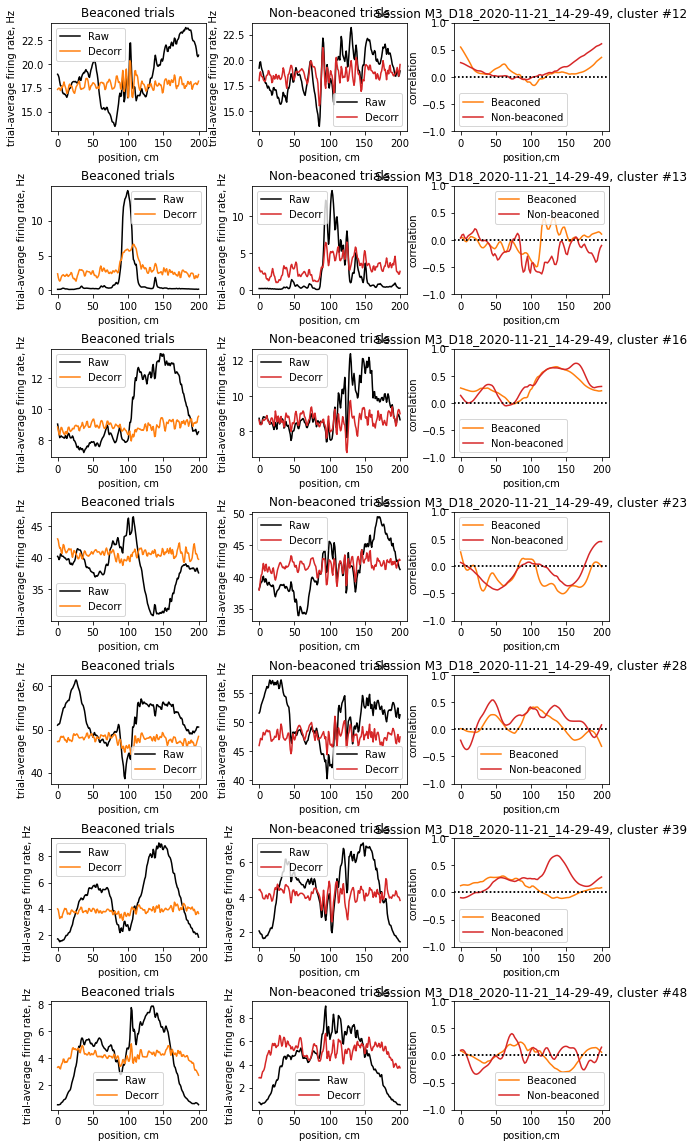

In [195]:
fig, axes = plt.subplots(7,3,figsize=(10,20))
device='cuda:0'
n_bins = 200
m=5
test_x = torch.linspace(0,1,100).float().to(device=device)
for ax, session_id in tqdm(zip(axes,[2,3,5,9,11,15,22])):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    train_x = torch.tensor(pos_t0).float().to(device=device)
    train_y = torch.tensor(np.array([u_rate_t0,u_vel_t0]).T).float().to(device=device)

    likelihoods = [bvcopula.GaussianCopula_Likelihood()]
    %time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                         device=device, prior_rbf_length=1.)
    print(f"WAIC: {waic}")
    
    model.gp_model.eval()
    with torch.no_grad():
        f = model.gp_model(train_x).mean
    copula = model.likelihood.get_copula(f) 
    cond_u = copula.ccdf(train_y).cpu().numpy()
    cond_y = cond_interp(cond_u,u_rate_t0,ds_rate_t0,pos_t0,bins=10)
    
    theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta,label='Beaconed',c='C1')
    ax[2].axhline(0,color='k',linestyle=':')
    
    averages = np.empty((2,n_bins))
    for i in tqdm(range(n_bins)):
        mask = (pos_t0>=(i-m)/n_bins) & (pos_t0 <=(i+1+m)/n_bins)
        w = np.exp(-(pos_t0[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
        w = w/w.sum()
        averages[0,i] =  20*(ds_rate_t0[mask] * w).sum()
        averages[1,i] =  20*(cond_y[mask] * w).sum()
    for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k','C1'])):
        ax[0].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
    ax[0].set_xlabel('position, cm')
    ax[0].set_ylabel('trial-average firing rate, Hz')
    ax[0].set_title('Beaconed trials')
    ax[0].legend()
    
    train_x = torch.tensor(pos_t1).float().to(device=device)
    train_y = torch.tensor(np.array([u_rate_t1,u_vel_t1]).T).float().to(device=device)

    likelihoods = [bvcopula.GaussianCopula_Likelihood()]
    %time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                         device=device, prior_rbf_length=1.)
    print(f"WAIC: {waic}")
    
    model.gp_model.eval()
    with torch.no_grad():
        f = model.gp_model(train_x).mean
    copula = model.likelihood.get_copula(f) 
    cond_u = copula.ccdf(train_y).cpu().numpy()
    cond_y = cond_interp(cond_u,u_rate_t1,ds_rate_t1,pos_t1,bins=10)
    
    theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta,label='Non-beaconed',c='C3')
    ax[2].axhline(0,color='k',linestyle=':')
    ax[2].set_ylim([-1,1])
    ax[2].set_xlabel('position,cm')
    ax[2].set_ylabel('correlation')
    ax[2].set_title(f'{session}, #{data.iloc[session_id].cluster_id}')
    ax[2].legend()
    
    averages = np.empty((2,n_bins))
    for i in tqdm(range(n_bins)):
        mask = (pos_t1>=(i-m)/n_bins) & (pos_t1 <=(i+1+m)/n_bins)
        w = np.exp(-(pos_t1[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
        w = w/w.sum()
        averages[0,i] =  20*(ds_rate_t1[mask] * w).sum()
        averages[1,i] =  20*(cond_y[mask] * w).sum()
    for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k','C3'])):
        ax[1].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
    ax[1].set_xlabel('position, cm')
    ax[1].set_ylabel('trial-average firing rate, Hz')
    ax[1].set_title('Non-beaconed trials')
    ax[1].legend()
fig.subplots_adjust(wspace=0.3,hspace=0.5)

In [219]:
likelihoods = [bvcopula.GaussianCopula_Likelihood()]
WAICs, thetas, cond_y = [None for _ in range(len(data))],\
                        [None for _ in range(len(data))],\
                        [None for _ in range(len(data))]
for session_id in tqdm(range(len(data))):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    WAICs[session_id] = [None, None]
    thetas[session_id] = [None, None]
    cond_y[session_id] = [None, None]
    
    for i, (A, u_A, rate_A, u_vel, pos) in enumerate([\
                            ("beaconed",u_rate_t0, ds_rate_t0, u_vel_t0, pos_t0), \
                            ("non-beaconed",u_rate_t1, ds_rate_t1, u_vel_t1, pos_t1)]):
                                                  
        train_x = torch.tensor(pos).float().to(device=device)
        train_y = torch.tensor([u_A,u_vel]).t().float().to(device=device)

        (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                         device=device, prior_rbf_length=1.)
        
        WAICs[session_id][i] = waic
        print(f"WAIC: {waic}")
        
        model.gp_model.eval()
        theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
        thetas[session_id][i] = theta
        with torch.no_grad():
            f = model.gp_model(train_x).mean
        copula = model.likelihood.get_copula(f) 
        cond_u = copula.ccdf(train_y).cpu().numpy()
        cond_y[session_id][i] = cond_interp(cond_u,u_A,rate_A,pos)
    
data['Gauss_WAICs'] = WAICs
data['Gauss_theta'] = thetas
data['spikes_lin_uncorr_from_vel'] = cond_y

  0%|          | 0/23 [00:00<?, ?it/s]

WAIC: -0.0016254306538030505
Fixing min
WAIC: -0.003221343271434307
Fixing min
Fixing min
Fixing max
Fixing max
WAIC: -0.022457875311374664
Fixing max
Fixing min
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
WAIC: -0.04783829301595688
Fixing min
Fixing max
Fixing min
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
WAIC: -0.008339865133166313
Fixing max
Fixing max
Fixing max
Fixing min
Fixing max
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
WAIC: -0.015278534963726997
Fixing max
Fixing min
Fixing max
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max
WAIC: -0.02462659403681755
Fixing min
Fixing min
WAIC: -0.06569335609674454
Fixing min
Fixing min
Fixing min
WAIC: -0

WAIC: -0.00892695039510727
Fixing min
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
Fixing max
WAIC: -0.010141675360500813
Fixing max
Fixing max
Fixing max
Fixing min
Fixing max


0it [00:00, ?it/s]

WAIC: [-0.008339865133166313, -0.015278534963726997]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.02462659403681755, -0.06569335609674454]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.04119817167520523, -0.07195586711168289]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.021624360233545303, -0.018633611500263214]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.023029744625091553, -0.03568847477436066]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.0106377974152565, -0.03571740910410881]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

WAIC: [-0.00892695039510727, -0.010141675360500813]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

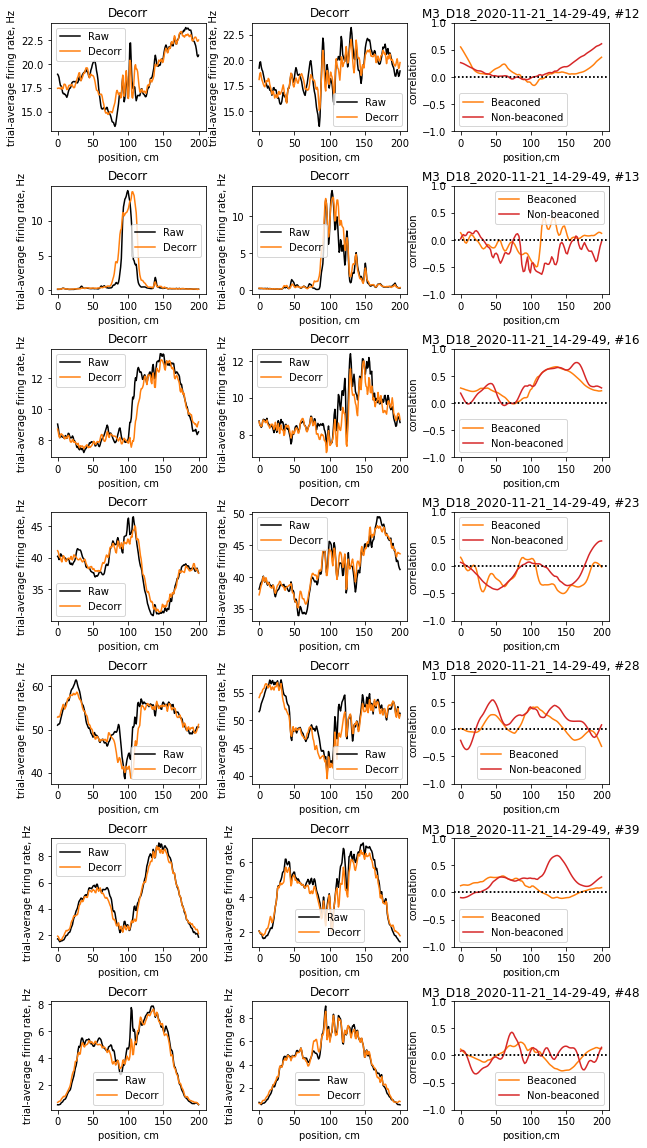

In [222]:
fig, axes = plt.subplots(7,3,figsize=(10,20))
n_bins = 200
m=5 # kernel weights for smoothing in plots, in bins
test_x = torch.linspace(0,1,100).float().to(device=device)
for ax, session_id in tqdm(zip(axes,[2,3,5,9,11,15,22])):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    waic = data.iloc[session_id].Gauss_WAICs
    theta = data.iloc[session_id].Gauss_theta
    cond_y = data.iloc[session_id].spikes_lin_uncorr_from_vel
    print(f"WAIC: {waic}")
    
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta[0],label='Beaconed',c='C1')
    ax[2].axhline(0,color='k',linestyle=':')
    ax[2].plot(np.linspace(0,LENGTH,len(test_x)),theta[1],label='Non-beaconed',c='C3')
    ax[2].axhline(0,color='k',linestyle=':')
    ax[2].set_ylim([-1,1])
    ax[2].set_xlabel('position,cm')
    ax[2].set_ylabel('correlation')
    ax[2].set_title(f'{session}, #{data.iloc[session_id].cluster_id}')
    ax[2].legend()
    
    for j, (label, pos, ds_rate) in enumerate(zip(['Beaconed trials','Non-beaconed trials'],\
                                             [pos_t0,pos_t1], [ds_rate_t0, ds_rate_t1])):
        averages = np.empty((2,n_bins))
        for i in tqdm(range(n_bins)):
            mask = (pos>=(i-m)/n_bins) & (pos <=(i+1+m)/n_bins)
            w = np.exp(-(pos[mask]-(i+0.5)/n_bins)**2/(2*0.005**2))
            w = w/w.sum()
            averages[0,i] =  20*(ds_rate[mask] * w).sum() # x 20 to get to Hz from 50ms bins
            averages[1,i] =  20*(cond_y[j][mask] * w).sum()
        for i,(label,c) in enumerate(zip(['Raw','Decorr'],['k','C1'])):
            ax[j].plot(np.linspace(0,LENGTH,n_bins),averages[i],label=label,c=c)
        ax[j].set_xlabel('position, cm')
        ax[j].set_ylabel('trial-average firing rate, Hz')
        ax[j].set_title(label)
        ax[j].legend()
        
fig.subplots_adjust(wspace=0.3,hspace=0.5)

# Non-gauss

In [225]:
import copulagp.select_copula as select_copula

WAICs, names, cond_y =  [None for _ in range(len(data))], \
                        [None for _ in range(len(data))], \
                        [None for _ in range(len(data))]
for session_id in tqdm(range(len(data))):
    u_vel_t0=data.iloc[session_id].u_vel_t0
    u_rate_t0=data.iloc[session_id].u_rate_t0
    u_vel_t1=data.iloc[session_id].u_vel_t1
    u_rate_t1=data.iloc[session_id].u_rate_t1
    [ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    
    WAICs[session_id] = [None, None]
    names[session_id] = [None, None]
    cond_y[session_id] = [None, None]
    
    for i, (A, u_A, rate_A, u_vel, pos) in enumerate([\
                            ("beaconed",u_rate_t0, ds_rate_t0, u_vel_t0, pos_t0), \
                            ("non-beaconed",u_rate_t1, ds_rate_t1, u_vel_t1, pos_t1)]):

        train_x = torch.tensor(pos).float().to(device=device)
        train_y = torch.tensor([u_A,u_vel]).t().float().to(device=device)

        (store, waic) = select_copula.select_with_heuristics(ds_pos,train_y.cpu().numpy(),device,'cond',\
                                                './',f'Cluster {session_id}','Velocity',train_x=train_x,train_y=train_y)
        WAICs[session_id][i] = waic
        names[session_id][i] = store.name_string
        print(f"Best model: {store.name_string}, WAIC: {waic}")
        with open(f"{A}_models/model{session_id}_vel.pkl","wb") as f:
            pkl.dump(store,f)
        model = store.model_init(device)

        model.gp_model.eval()
        with torch.no_grad():
            f = model.gp_model(train_x).mean
        copula = model.likelihood.get_copula(f) 
        cond_u = copula.ccdf(train_y).cpu().numpy()
        cond_y[session_id][i] = cond_interp(cond_u,u_A[:,n],rate_A[:,n],ds_pos)
    
data['WAICs'] = WAICs
data['copula model'] = names
data['spikes_nonlin_uncorr_from_vel'] = cond_y

  0%|          | 0/23 [00:00<?, ?it/s]

Best model: Independence, WAIC: -0.0016292876098304987


NameError: name 'n' is not defined